## Binary classificator

We're going to realize a simple neural network that takes two inputs and returns either 0 or 1. First, let's create a designed dataset for our purpose. 

In [1]:
# Importing a dataset generator from sklearn
from sklearn.datasets import make_circles

# Importing a dataset splitter from sklearn
from sklearn.model_selection import train_test_split

# Importing an accuracy tool from sklearn
from sklearn.metrics import accuracy_score

# Importing Dataframe from Pandas
from pandas import DataFrame, RangeIndex

# Importing PyTorch
import torch

# Importing NumPy
import numpy as np

# Plotting stuff
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
plt.style.use('bmh')

In [2]:
# Creating a dataset: input (x, y) then output z
n_samples = 1000
noise = 0.03
factor = 0.7

dataset = make_circles(n_samples = n_samples,
                       shuffle = True,
                       noise = noise,
                       random_state = 47,
                       factor = factor)

In [3]:
# Visualizing the dataset
input, output = dataset

df = DataFrame({'x': input[:, 0],
                'y': input[:, 1],
                'z': output},
                index = RangeIndex(start = 1, stop = n_samples + 1, name = 'point'))
df.head(20)

,x,y,z
point,,,
1,0.657123,0.292465,1
2,0.361765,-0.551110,1
3,0.340110,0.587448,1
4,0.968575,0.296591,0
5,-0.529314,-0.820368,0
6,-0.519510,0.543661,1
7,0.435279,0.542094,1
8,0.206876,-0.717856,1
9,0.474789,-0.467885,1


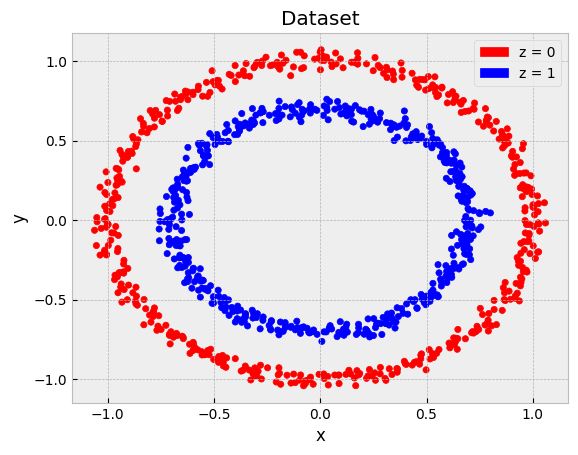

In [4]:
# Visualizing the dataset
colors = ['red', 'blue']
cmap = ListedColormap(colors)

df.plot(x = 'x', 
        y = 'y', 
        kind = 'scatter', 
        c = 'z', 
        cmap = cmap,
        colorbar = False,
        title = 'Dataset')

blue_patch = mpatches.Patch(color = 'red', label = 'z = 0')
red_patch = mpatches.Patch(color = 'blue', label = 'z = 1')
plt.legend(handles = [blue_patch, red_patch], loc = 'best')
plt.show()

In [5]:
# Computing the radii squared
df_0 = df[df['z'] == 0]
df_1 = df[df['z'] == 1]

In [6]:
# Radius squared of the blue circle
round((df_0['x'] ** 2 + df_0['y'] ** 2).mean().item(), 3)

1.004

In [7]:
# Radius squared of the red circle
round((df_1['x'] ** 2 + df_1['y'] ** 2).mean().item(), 3) # The radius is about 0.70, equivalent to the 'factor' parameter of 'make_circle'

0.492

Before building and training the neural network, let's prepare the dataset by making PyTorch tensors and splitting it

In [8]:
# Conversion to float32 numbers
input = np.float32(input)
output = np.float32(output)

# Output shape (n_points, 1) while input shape is (n_points, 2)
output = output.reshape(len(output), 1)

# Splitting data
input_train, input_test, output_train, output_test = train_test_split(input,
                                                                      output,
                                                                      test_size = 0.2,
                                                                      shuffle = True,
                                                                      random_state = 47)

# Tensors transformations
input_train_tensor = torch.from_numpy(input_train)
input_test_tensor = torch.from_numpy(input_test)
output_train_tensor = torch.from_numpy(output_train)
output_test_tensor = torch.from_numpy(output_test)

Now let's build the model and train it on the training set.

In [9]:
# Model with nn.Sequential
BinaryClassificator = torch.nn.Sequential(
    torch.nn.Linear(in_features = 2, out_features = 10),
    torch.nn.Linear(in_features = 10, out_features = 10),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 10, out_features = 1)
 )

In [10]:
# Setting up the loss function: Binary Cross Entropy + Sigmoid function activator
loss_function = torch.nn.BCEWithLogitsLoss()

In [11]:
# Setting up the optimizer: Stochastic Gradient Descent
optimizer = torch.optim.SGD(BinaryClassificator.parameters(), lr = 0.1)

In [12]:
# Defining a learning rate decay
decay_function = lambda epoch: 0.9996 ** epoch  # Exponential decay
decay_lr = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = decay_function)

In [13]:
# Training parameters
max_epochs = 20_000
patience = 2_000
min_delta = 1e-04

# Lists to track progress
train_loss_list = []
test_loss_list = []
decay_lr_list = []

# Early stopping variables
best_loss = float('inf')
epochs_no_improve = 0
early_stop_flag = False

# Training loop with early stopping
for epoch in range(max_epochs):
    if early_stop_flag:
        print(f"Early stopping triggered at epoch {epoch}")
        break
        
    # Training setup
    BinaryClassificator.train()
    
    # Forward pass
    train_logits = BinaryClassificator(input_train_tensor)
    
    # Calculate loss
    train_loss = loss_function(train_logits, output_train_tensor)
    
    # Backward pass and optimize
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    decay_lr.step()

    lr_value = decay_lr.get_last_lr()[0]
    
    # Evaluation phase
    BinaryClassificator.eval()
    with torch.inference_mode():
        test_logits = BinaryClassificator(input_test_tensor)
        test_loss = loss_function(test_logits, output_test_tensor)
    
    # Record losses
    train_loss_list.append(train_loss.item())
    test_loss_list.append(test_loss.item())
    decay_lr_list.append(lr_value)
    
    # Check for improvement
    if test_loss.item() + min_delta < best_loss:  # Note: using test loss for early stopping
        best_loss = test_loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        
    # Check early stopping condition
    if epochs_no_improve >= patience:
        early_stop_flag = True
    
    # Print progress
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Train Loss = {train_loss.item():.4f}, Test Loss = {test_loss.item():.4f}, Learning rate = {lr_value:.4f}')

print("Training completed!")
print(f"Last learning rate: {(lr_value):.4f}")

Epoch 0: Train Loss = 0.7032, Test Loss = 0.7023, Learning rate = 0.1000
Epoch 1000: Train Loss = 0.2074, Test Loss = 0.2155, Learning rate = 0.0670
Epoch 2000: Train Loss = 0.0259, Test Loss = 0.0273, Learning rate = 0.0449
Epoch 3000: Train Loss = 0.0136, Test Loss = 0.0149, Learning rate = 0.0301
Epoch 4000: Train Loss = 0.0100, Test Loss = 0.0112, Learning rate = 0.0202
Epoch 5000: Train Loss = 0.0084, Test Loss = 0.0096, Learning rate = 0.0135
Epoch 6000: Train Loss = 0.0076, Test Loss = 0.0087, Learning rate = 0.0091
Epoch 7000: Train Loss = 0.0072, Test Loss = 0.0082, Learning rate = 0.0061
Epoch 8000: Train Loss = 0.0069, Test Loss = 0.0079, Learning rate = 0.0041
Epoch 9000: Train Loss = 0.0067, Test Loss = 0.0077, Learning rate = 0.0027
Epoch 10000: Train Loss = 0.0066, Test Loss = 0.0076, Learning rate = 0.0018
Epoch 11000: Train Loss = 0.0065, Test Loss = 0.0075, Learning rate = 0.0012
Epoch 12000: Train Loss = 0.0064, Test Loss = 0.0075, Learning rate = 0.0008
Epoch 13000:

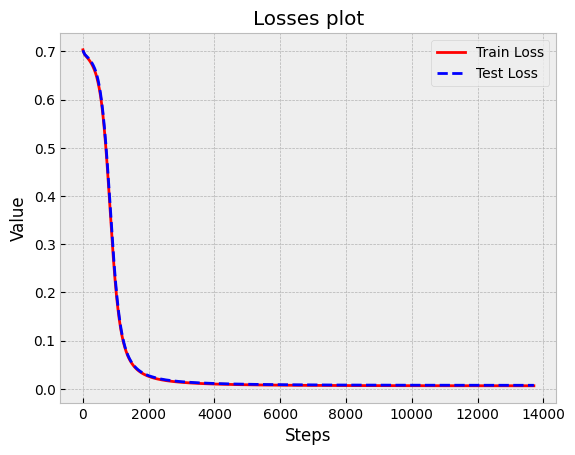

In [14]:
# Plotting losses
plt.plot(train_loss_list, label = 'Train Loss', color = 'red')
plt.plot(test_loss_list, label = 'Test Loss', color = 'blue', linestyle = '--')
plt.title('Losses plot')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle = '--')
plt.show()

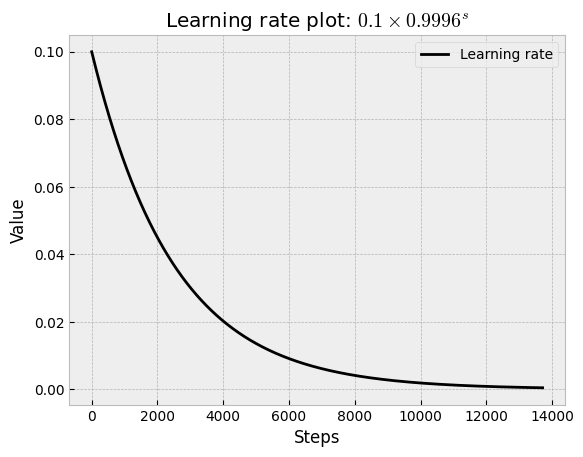

In [15]:
# Plotting learning rate decay
plt.plot(decay_lr_list, label = 'Learning rate', color = 'black')
plt.title(r'Learning rate plot: $0.1 \times 0.9996^s$')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle = '--')
plt.show()

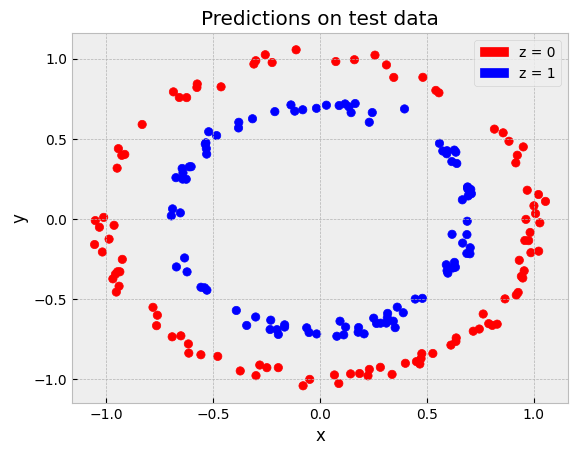

In [16]:
# Test on test data
BinaryClassificator.eval()
with torch.inference_mode():
    predictions_logits = BinaryClassificator(input_test_tensor)

probabilities = torch.sigmoid(predictions_logits)
predictions = torch.round(probabilities)

# From tensor to NumPy array
predictions = predictions.squeeze().numpy()

# Plotting
plt.scatter(input_test[:, 0], input_test[:, 1], c = predictions, cmap = cmap)
plt.legend(handles = [blue_patch, red_patch], loc = 'best')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predictions on test data')
plt.show()

In [17]:
# Defining a test function
def testing(n_samples, noise, random_state, factor):

    # Test the model on a new dataset
    fresh_dataset = make_circles(n_samples = n_samples,
                             shuffle = True,
                             noise = noise,
                             random_state = random_state,
                             factor = factor)

    fresh_input, fresh_output = fresh_dataset

    # Manipulations
    fresh_input = np.float32(fresh_input)
    fresh_output = np.float32(fresh_output)
    fresh_input_tensor = torch.from_numpy(fresh_input)

    # Testing again
    with torch.inference_mode():
        predictions_logits = BinaryClassificator(fresh_input_tensor)

    probabilities = torch.sigmoid(predictions_logits)
    predictions = torch.round(probabilities)
    predictions = predictions.squeeze().numpy()

    plt.scatter(fresh_input[:, 0], fresh_input[:, 1], c = predictions, cmap = cmap, s = 10)
    plt.legend(handles = [blue_patch, red_patch], loc = 'best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predictions on a new dataset')
    plt.show()

    # Computing accuracy (fixed in one line)
    print(f'Accuracy achieved: {round(accuracy_score(y_true = fresh_output.squeeze(),
                                                     y_pred = predictions,
                                                     normalize = True) * 100, 3)}%')
    return None

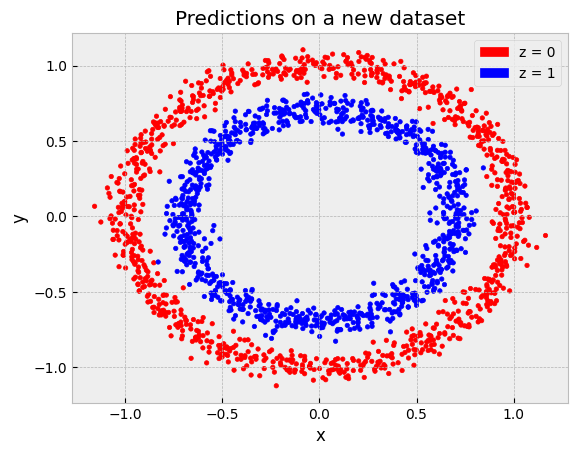

Accuracy achieved: 99.6%


In [18]:
testing(n_samples = 2 * n_samples, # Double data
        noise = noise + 0.02, # Added more noise
        random_state = 99, # New random state
        factor = factor) # Same factor

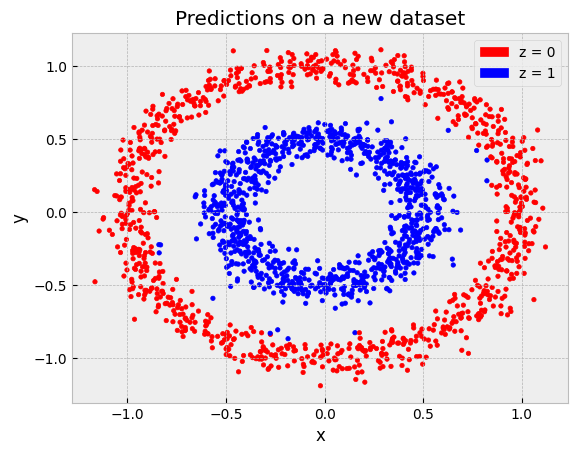

Accuracy achieved: 99.35%


In [19]:
testing(n_samples = 2 * n_samples, # Double data
        noise = noise + 0.04, # Added more noise
        random_state = 98, # New random state
        factor = factor - 0.2) # Smaller factor

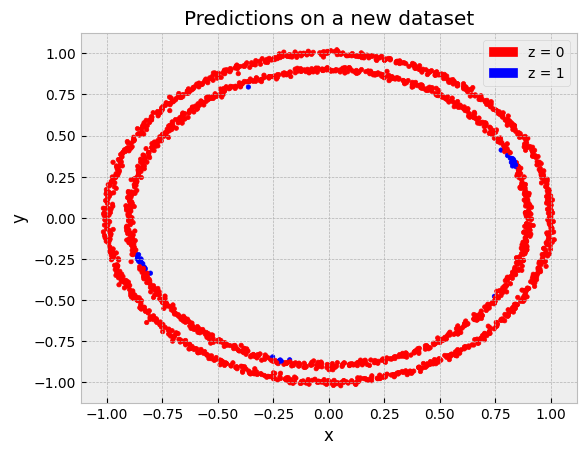

Accuracy achieved: 51.7%


In [ ]:
testing(n_samples = 2 * n_samples, # Double data
        noise = noise - 0.02, # Smaller noise
        random_state = 97, # New random state
        factor = factor + 0.2) # Greater factor

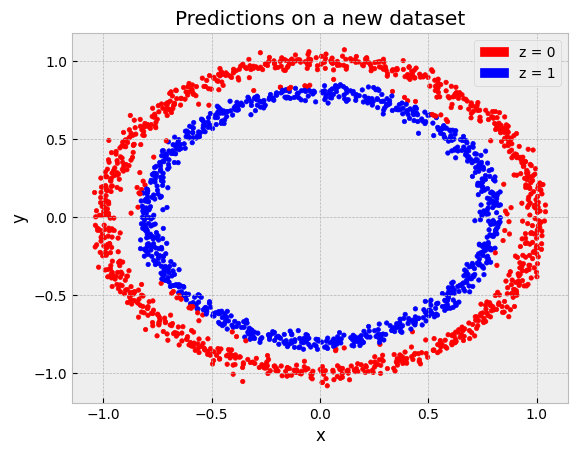

Accuracy achieved: 96.85%


In [21]:
testing(n_samples = 2 * n_samples, # Double data
        noise = noise, # Same noise
        random_state = 96, # New random state
        factor = factor + 0.1) # Factor a little bit bigger